# DataLab Cup 3: Reverse Image Caption

IDUDL   
112062611吳明真 110062619楊淨富 112138502陳炫妙

## Environment setting


In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras import layers
import os

import string
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import random
import time
from pathlib import Path

import re
from IPython import display

import tensorflow_hub as hub
import tensorflow_text


MAX_SEQ_LENGTH = 20

In [8]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [9]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Preprocess Text


In [11]:
dictionary_path = './dictionary'
vocab = np.load(dictionary_path + '/vocab.npy')
print('there are {} vocabularies in total'.format(len(vocab)))

word2Id_dict = dict(np.load(dictionary_path + '/word2Id.npy'))
id2word_dict = dict(np.load(dictionary_path + '/id2Word.npy'))
print('Word to id mapping, for example: %s -> %s' % ('flower', word2Id_dict['flower']))
print('Id to word mapping, for example: %s -> %s' % ('1', id2word_dict['1']))
print('Tokens: <PAD>: %s; <RARE>: %s' % (word2Id_dict['<PAD>'], word2Id_dict['<RARE>']))

there are 5427 vocabularies in total
Word to id mapping, for example: flower -> 1
Id to word mapping, for example: 1 -> flower
Tokens: <PAD>: 5427; <RARE>: 5428


In [12]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0
    
    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l
    
    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        word2Id_dict[tokens[k]]
        if tokens[k] in word2Id_dict else word2Id_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line

text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


## Dataset

In [13]:
data_path = './dataset'
df = pd.read_pickle(data_path + '/text2ImgData.pkl')
num_training_sample = len(df)
n_images_train = num_training_sample
print('There are %d image in training data' % (n_images_train))

There are 7370 image in training data


In [14]:
def id_to_string(df):
    for i in range(len(df)):
    #     if i > 1: break
        captures_word = []
        for cap in df['Captions'].iloc[i]:
            capture_word = ''
            for id_ in cap:
                word = id2word_dict[id_]
                if word == '<PAD>':
                    continue
                capture_word += word+' '
#             print(capture_word)
            captures_word.append(capture_word)
        df['Captions'].iloc[i] = captures_word

In [15]:
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

def training_data_generator(caption, image_path):

    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    img = img * 2. -1.
    
    ##
    if tf.random.uniform([]) < 0.25:
        img = tf.image.flip_left_right(img)
    if tf.random.uniform([]) < 0.25:
        img = tf.image.random_brightness(img, max_delta=0.2)

    return img, caption

def dataset_generator(filenames, batch_size, data_generator):
    # load the training data into two NumPy arrays
    df = pd.read_pickle(filenames)
    id_to_string(df)
    captions = df['Captions'].values
    caption = []
    image_path = []
    image_path_array=df['ImagePath'].values
    for embeddings, image_paths in zip(captions, image_path_array):
        for embedding in embeddings:
            caption.append(embedding)
            image_path.append(image_paths)
    caption = np.asarray(caption)    
    #assert caption.shape[0] == image_path.shape[0]
    print(len(caption), len(image_path))
    dataset = tf.data.Dataset.from_tensor_slices((caption, image_path))
    dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(caption)).batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [16]:
BATCH_SIZE = 64
dataset = dataset_generator(data_path + '/text2ImgData.pkl', BATCH_SIZE, training_data_generator)

70504 70504


In [17]:
print(dataset)

<PrefetchDataset shapes: ((64, 64, 64, 3), (64,)), types: (tf.float32, tf.string)>


## Text Encoder


In [18]:
class TextEncoder(tf.keras.Model):
    """
    Encode text (a captio n) into hidden representation
    input: text, which is a text
    output: embedding
    """
    def __init__(self):
        super(TextEncoder, self).__init__()
        module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
        self.text_encoder = hub.load(module_url)

    
    def call(self, text):
        return self.text_encoder(text)

## Define function

In [19]:
class conv(tf.keras.Model):
    def __init__(self, filters, size, stride):
        super(conv, self).__init__()
        self.conv = layers.Conv2D(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), use_bias=False)
        self.bn = layers.BatchNormalization()
        

    def call(self, inputs, training=False):
        x = self.bn(self.conv(inputs), training=training)
        return x
    
class conv_relu(tf.keras.Model):
    def __init__(self, filters, size, stride):
        super(conv_relu, self).__init__()
        self.conv = layers.Conv2D(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), use_bias=False)
        self.bn =layers.BatchNormalization()
        self.ReLU = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.bn(self.conv(inputs), training=training)
        x = self.ReLU(x)
        return x    

class conv_leaky_relu(tf.keras.Model):
    def __init__(self, filters, size, stride):
        super(conv_leaky_relu, self).__init__()
        self.conv = layers.Conv2D(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),  use_bias=False)
        self.bn = layers.BatchNormalization()
        self.LeakyReLU = layers.LeakyReLU(0.2)

    def call(self, inputs, training=False):
        x = self.bn(self.conv(inputs), training=training)
        x = self.LeakyReLU(x)
        return x
    
def UpSampleBlock(filters_num):
        
    return tf.keras.Sequential([
                tf.keras.layers.UpSampling2D(),
                tf.keras.layers.Conv2D(filters=filters_num, kernel_size=3, strides=1, padding='SAME',
                                       use_bias=False, kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)),
                tf.keras.layers.BatchNormalization(),

            ])
class convg(tf.keras.Model):
    def __init__(self, filters, size, stride):
        super(convg, self).__init__()
        self.conv = layers.Conv2DTranspose(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), use_bias=False)
        self.bn = layers.BatchNormalization()
        

    def call(self, inputs, training=False):
        x = self.bn(self.conv(inputs), training=training)
        return x
    
class conv_relug(tf.keras.Model):
    def __init__(self, filters, size, stride):
        super(conv_relug, self).__init__()
        self.conv = layers.Conv2DTranspose(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02), use_bias=False)
        self.bn =layers.BatchNormalization()
        self.ReLU = layers.ReLU()

    def call(self, inputs, training=False):
        x = self.bn(self.conv(inputs), training=training)
        x = self.ReLU(x)
        return x    

class conv_leaky_relug(tf.keras.Model):
    def __init__(self, filters, size, stride):
        super(conv_leaky_relug, self).__init__()
        self.conv = layers.Conv2DTranspose(filters, size, stride, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),  use_bias=False)
        self.bn = layers.BatchNormalization()
        self.LeakyReLU = layers.LeakyReLU(0.2)

    def call(self, inputs, training=False):
        x = self.bn(self.conv(inputs), training=training)
        x = self.LeakyReLU(x)
        return x
    
def UpSampleBlockg(filters_num):
        
    return tf.keras.Sequential([
                tf.keras.layers.UpSampling2D(),
                tf.keras.layers.Conv2DTranspose(filters=filters_num, kernel_size=3, strides=1, padding='SAME',
                                       use_bias=False, kernel_initializer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.02)),
                tf.keras.layers.BatchNormalization()

            ])

## Generator


In [20]:
class Generator(tf.keras.Model):
    def __init__(self, hparas):
        super(Generator, self).__init__()
        self.hparas = hparas

        self.hparas = hparas
        self.t_dim = 128
        self.gf_dim = 128
        self.image_size = 64
        self.c_dim = 3
        
        self.text_fc = tf.keras.layers.Dense(128, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                                              use_bias=False)
         
        self.dense_block = tf.keras.Sequential([
                tf.keras.layers.Dense(128*8*4*4, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),use_bias=False),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Reshape((4, 4, 128*8))
            ])
        
        self.upsample1 = UpSampleBlockg(filters_num=128*4)
        
        self.conv2_1 = conv_leaky_relug(128,1,1)
        self.conv2_2 = conv_leaky_relug(128,3,1)
        self.conv2_3 = convg(512,3,1)
        
        self.upsample2 = UpSampleBlockg(128*2)
        self.upsample3 = UpSampleBlockg(128)
        self.upsample4 = UpSampleBlockg(64)
        self.conv_o = convg(3, 3, 1)
   

    def call(self, text, noise_z, training):

        x_in = tf.concat([noise_z, text], axis=1)

        x_0 = self.dense_block(x_in, training=training) #(-1*4*4*1024)
        
        x_2 = self.upsample1(x_0)  #(-1*8*8*512)
        x_2 = tf.nn.relu(x_2)
        x = self.conv2_1(x_2)
        x = self.conv2_2(x)
        x = self.conv2_3(x)
        
        x_3 = tf.add_n([x_2, x])  
        x_3_output = tf.nn.relu(x_3) 

        x_4 = self.upsample2(x_3_output)  #(-1*16*16*256)
        x_4 = tf.nn.relu(x_4)
        x_5 = self.upsample3(x_4)  #(-1*32*32*128)
        x_5 = tf.nn.relu(x_5)
        x_6 = self.upsample4(x_5) #(-1*64*64*256)
        x_6 = tf.nn.relu(x_6)
        x_o =  self.conv_o(x_6)
        logits = x_o
        outputs = tf.nn.tanh(x_o)

        return logits, outputs

## Discriminator

In [21]:
class Discriminator(tf.keras.Model):
    def __init__(self, hparas):
        super(Discriminator, self).__init__()
        self.hparas = hparas
        self.conv0 = layers.Conv2D(64, 4, 2, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                                   use_bias=False)
        self.conv1 = conv_leaky_relu(128,4,2)
        self.conv2 = conv_leaky_relu(256,4,2)
        self.conv3 = conv_leaky_relu(512,4,2)
        
        self.conv4_1 = conv_leaky_relu(128,1,1)
        self.conv4_2 = conv_leaky_relu(128,3,1)
        self.conv4_3 = conv_leaky_relu(512,3,1)
        
        self.text_fc = tf.keras.layers.Dense(128, kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),  use_bias=False)
        self.leakyRelu1 = layers.LeakyReLU(0.1)
        self.conv5 = conv_leaky_relu(512,3,1)
        self.conv6 = layers.Conv2D(1, 4, 4, padding="same", kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                                    use_bias=False)
    def call(self, input_image, input_text, training):
        x = self.conv0(input_image,training=training)
        x = tf.nn.leaky_relu(x)
        x = self.conv1(x,training=training)
        x = self.conv2(x,training=training)
        x = self.conv3(x,training=training)

        x_1 = self.conv4_1(x,training=training)
        x_1 = self.conv4_2(x_1,training=training)
        x_1 = self.conv4_3(x_1,training=training)

        x_2 = tf.add_n([x_1, x])
        x_2 = tf.nn.leaky_relu(x_2)

        t = self.text_fc(input_text,training=training)
        t = tf.reshape(t, (-1, 1, 1, 128))
        t = tf.tile(t, [1, 4, 4, 1])

        x_t_concat = tf.concat([x_2, t], axis=3)

        x_t =  self.conv5(x_t_concat,training=training)
        logits = self.conv6(x_t,training=training)
        output = tf.nn.sigmoid(logits)
        
        return logits, output

# Hyperparameter and model declaration

In [22]:
hparas = {
    'MAX_SEQ_LENGTH': 20,                     # maximum sequence length
#   'EMBED_DIM': 256,                         # word embedding dimension
    'EMBED_DIM': 512,
    'VOCAB_SIZE': len(word2Id_dict),          # size of dictionary of captions
    'RNN_HIDDEN_SIZE': 128,                   # number of RNN neurons
    'Z_DIM': 512,                             # random noise z dimension
    'DENSE_DIM': 128,                         # number of neurons in dense layer
    'IMAGE_SIZE': [64, 64, 3],                # render image size
    'BATCH_SIZE': 64,
    'LR':  0.0002,
    'LR_DECAY': 0.5,
    'BETA_1': 0.5,
    'NOISE_DECAY_LIMIT': 30,
    'N_EPOCH': 60,
    'N_SAMPLE': num_training_sample,          # size of training data
    'CHECKPOINTS_DIR': './ckptYu70Decayff',  # checkpoint path
    'PRINT_FREQ': 1,                          # printing frequency of loss
    'SHOW_IMAGES': 10, 
    'BETA_2':0.99
}

In [23]:
text_encoder = TextEncoder()
generator = Generator(hparas)
discriminator = Discriminator(hparas)

## Loss Function and Optimization

In [24]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [25]:
def discriminator_loss(real_logits, fake_logits, wrong_logits):

    # output value of real image should be 1
    real_loss = cross_entropy(tf.ones_like(real_logits), real_logits)
    # output value of fake image should be 0
    fake_loss = cross_entropy(tf.zeros_like(fake_logits), fake_logits)

    wrong_loss = cross_entropy(tf.zeros_like(wrong_logits), wrong_logits)

    total_loss = real_loss + fake_loss + wrong_loss#real_loss + 0.5*(fake_loss + wrong_loss)

    return total_loss

def generator_loss(fake_output):
    # output value of fake image should be 0
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [26]:
# we use seperated optimizers for training generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(hparas['LR'], hparas['BETA_1'])
discriminator_optimizer = tf.keras.optimizers.Adam(hparas['LR'], hparas['BETA_1'])

# Check points


In [27]:
# one benefit of tf.train.Checkpoint() API is we can save everything seperately
checkpoint_dir = hparas['CHECKPOINTS_DIR']
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 text_encoder=text_encoder,
                                 generator=generator,
                                 discriminator=discriminator)

In [28]:
print(checkpoint)

## train step

In [29]:
@tf.function
def train_step_D(real_image, caption, noise_decay):
    # random noise for generator

    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']])
    # 因為有增加資料
    wrong_caption = tf.concat([caption[10:], tf.expand_dims(caption[0], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[1], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[2], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[3], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[4], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[5], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[6], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[7], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[8], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[9], 0)], axis=0)
    
    with tf.GradientTape() as disc_tape:
        text_embed = text_encoder(caption)
        wrong_text_embed = text_encoder(wrong_caption)
        _, fake_image = generator(text_embed, noise, True)
        
        fake_image = fake_image + noise_decay * tf.random.normal(fake_image.shape)
        real_image = real_image + noise_decay * tf.random.normal(real_image.shape)

        real_logits, real_output = discriminator(real_image, text_embed, True)
        fake_logits, fake_output = discriminator(fake_image, text_embed, True)
        wrong_logits, wrong_output = discriminator(real_image, wrong_text_embed, training=True)
        
        # for gradient penalty
        epsilon = tf.compat.v2.random.uniform([hparas['BATCH_SIZE'], 1, 1, 1], 0., 1.)
        mix_image = epsilon*real_image + (1. - epsilon)*fake_image
        mix_image = mix_image+ noise_decay * tf.random.normal(mix_image.shape)
        mix_logits, mix_output = discriminator(mix_image, text_embed, training=True)
           
        grad = tf.square(tf.sqrt(tf.reduce_sum(tf.square(tf.gradients(mix_logits, mix_image)[0]), axis=[1, 2])) - 1.)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, wrong_logits) + 10.*tf.reduce_mean(grad)

    grad_d = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(grad_d, discriminator.trainable_variables))
    
    return g_loss, d_loss

In [30]:
@tf.function
def train_step_G(real_image, caption, noise_decay):
    # random noise for generator
 
    noise = tf.random.normal(shape=[hparas['BATCH_SIZE'], hparas['Z_DIM']])
    
    wrong_caption = tf.concat([caption[10:], tf.expand_dims(caption[0], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[1], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[2], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[3], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[4], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[5], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[6], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[7], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[8], 0)], axis=0)
    wrong_caption = tf.concat([wrong_caption, tf.expand_dims(caption[9], 0)], axis=0)

    with tf.GradientTape() as gen_tape:
        text_embed = text_encoder(caption)
        wrong_text_embed = text_encoder(wrong_caption)
        _, fake_image = generator(text_embed, noise, True)
        fake_image = fake_image + noise_decay * tf.random.normal(fake_image.shape)
        real_image = real_image + noise_decay * tf.random.normal(real_image.shape)

        real_logits, real_output = discriminator(real_image, text_embed, True)
        fake_logits, fake_output = discriminator(fake_image, text_embed, True)
        wrong_logits, wrong_output = discriminator(real_image, wrong_text_embed, training=True)
        
        # for gradient penalty
        epsilon = tf.compat.v2.random.uniform([hparas['BATCH_SIZE'], 1, 1, 1], 0., 1.)
        mix_image = epsilon*real_image + (1. - epsilon)*fake_image
        mix_image = mix_image+ noise_decay * tf.random.normal(mix_image.shape)
        mix_logits, mix_output = discriminator(mix_image, text_embed, training=True)
           
        grad = tf.square(tf.sqrt(tf.reduce_sum(tf.square(tf.gradients(mix_logits, mix_image)[0]), axis=[1, 2])) - 1.)

        g_loss = generator_loss(fake_logits)
        d_loss = discriminator_loss(real_logits, fake_logits, wrong_logits) + 10.*tf.reduce_mean(grad)

    grad_g = gen_tape.gradient(g_loss, generator.trainable_variables)

    generator_optimizer.apply_gradients(zip(grad_g, generator.trainable_variables))
    return g_loss, d_loss

## test step

In [31]:
@tf.function
def test_step(caption, noise):
    text_embed = text_encoder(caption)
    #print(text_embed)
    _, fake_image = generator(text_embed, noise)
    return fake_image

## Visualiztion

In [32]:
def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1], 3))
    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w, :] = image
    return img

def imsave(images, size, path):
    # getting the pixel values between [0, 1] to save it
    return plt.imsave(path, merge(images, size)*0.5 + 0.5)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

In [33]:
def sample_generator(caption, batch_size):
    caption = np.asarray(caption)
    caption = caption.astype(np.int)
    dataset = tf.data.Dataset.from_tensor_slices(caption)
    dataset = dataset.batch(batch_size)
    return dataset

In [34]:
ni = int(np.ceil(np.sqrt(hparas['BATCH_SIZE'])))
sample_size = hparas['BATCH_SIZE']
sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
sample_sentence = ["the flower shown has yellow anther red pistil and bright red petals."] * int(sample_size/ni) + \
                  ["this flower has petals that are yellow, white and purple and has dark lines"] * int(sample_size/ni) + \
                  ["the petals on this flower are white with a yellow center"] * int(sample_size/ni) + \
                  ["this flower has a lot of small round pink petals."] * int(sample_size/ni) + \
                  ["this flower is orange in color, and has petals that are ruffled and rounded."] * int(sample_size/ni) + \
                  ["the flower has yellow petals and the center of it is brown."] * int(sample_size/ni) + \
                  ["this flower has petals that are blue and white."] * int(sample_size/ni) +\
                  ["these white flowers have petals that start off white in color and end in a white towards the tips."] * int(sample_size/ni)

sample_sentence = tf.data.Dataset.from_tensor_slices(sample_sentence).batch(hparas['BATCH_SIZE'])

## Training

In [35]:
# ratio of training step D:G = 5:1
ratio = 6

def train(dataset, epochs):
    steps_per_epoch = int(hparas['N_SAMPLE'] / hparas['BATCH_SIZE'])
    turn = 0
    
    for epoch in range(hparas['N_EPOCH']):
        g_total_loss = 0
        d_total_loss = 0
        start = time.time()
        sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
        if epoch < hparas['NOISE_DECAY_LIMIT']:
            noise_decay = 1 / (epoch + 1)
        else:
            noise_decay = 0
        
        for image, caption in dataset:
            if (turn + 1) == ratio:
                g_loss, d_loss = train_step_G(image, caption, noise_decay)
            else:
                g_loss, d_loss = train_step_D(image, caption, noise_decay)
            turn = (turn + 1) % ratio
            g_total_loss += g_loss
            d_total_loss += d_loss
            
        time_tuple = time.localtime()
        time_string = time.strftime("%m/%d/%Y, %H:%M:%S", time_tuple)
            
        
        
        # visualization
        if (epoch + 1) % hparas['PRINT_FREQ'] == 0:
            for caption in sample_sentence:
                fake_image = test_step(caption, sample_seed)
            save_images(fake_image, [ni, ni], './samples/train_{:02d}.jpg'.format(epoch))
            checkpoint.save(file_prefix = checkpoint_prefix)
            print("Epoch {}, gen_loss: {:.4f}, disc_loss: {:.4f}".format(epoch+1,
                                                                     g_total_loss/steps_per_epoch,
                                                                     d_total_loss/steps_per_epoch))
            print('Time for epoch {} is {:.4f} sec'.format(epoch+1, time.time()-start))
        
        # show the generated images
        if (epoch + 1) % hparas['SHOW_IMAGES'] == 0:    
            img = Image.open('./samples/train_{:02d}.jpg'.format(epoch))
            display.display(img)

Epoch 1, gen_loss: 37.5899, disc_loss: 11.5556
Time for epoch 1 is 67.6546 sec
Epoch 2, gen_loss: 33.3549, disc_loss: 5.9425
Time for epoch 2 is 63.4854 sec
Epoch 3, gen_loss: 26.5928, disc_loss: 7.4675
Time for epoch 3 is 64.3905 sec
Epoch 4, gen_loss: 19.7642, disc_loss: 9.0016
Time for epoch 4 is 64.5372 sec
Epoch 5, gen_loss: 18.3553, disc_loss: 8.4651
Time for epoch 5 is 64.3327 sec
Epoch 6, gen_loss: 16.8337, disc_loss: 9.0606
Time for epoch 6 is 63.9334 sec
Epoch 7, gen_loss: 15.3063, disc_loss: 8.9382
Time for epoch 7 is 64.3100 sec
Epoch 8, gen_loss: 15.1184, disc_loss: 9.1086
Time for epoch 8 is 63.5207 sec
Epoch 9, gen_loss: 15.1268, disc_loss: 8.5607
Time for epoch 9 is 64.1058 sec
Epoch 10, gen_loss: 15.3932, disc_loss: 8.2967
Time for epoch 10 is 64.0858 sec


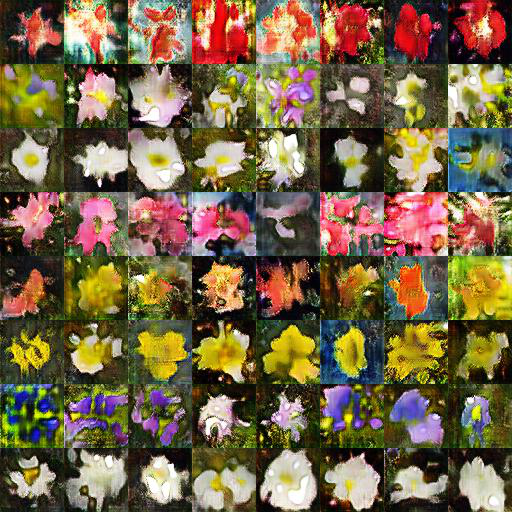

Epoch 11, gen_loss: 15.7143, disc_loss: 7.9330
Time for epoch 11 is 63.6577 sec
Epoch 12, gen_loss: 17.0183, disc_loss: 7.2226
Time for epoch 12 is 64.1850 sec
Epoch 13, gen_loss: 18.0853, disc_loss: 6.5726
Time for epoch 13 is 63.8533 sec
Epoch 14, gen_loss: 20.2911, disc_loss: 5.9996
Time for epoch 14 is 64.1345 sec
Epoch 15, gen_loss: 19.4601, disc_loss: 6.0900
Time for epoch 15 is 64.3752 sec
Epoch 16, gen_loss: 19.3038, disc_loss: 8.3316
Time for epoch 16 is 64.0830 sec
Epoch 17, gen_loss: 16.8913, disc_loss: 6.3637
Time for epoch 17 is 64.2035 sec
Epoch 18, gen_loss: 23.1812, disc_loss: 4.5549
Time for epoch 18 is 63.2707 sec
Epoch 19, gen_loss: 22.0949, disc_loss: 4.9768
Time for epoch 19 is 63.8756 sec
Epoch 20, gen_loss: 25.9367, disc_loss: 4.1068
Time for epoch 20 is 64.1066 sec


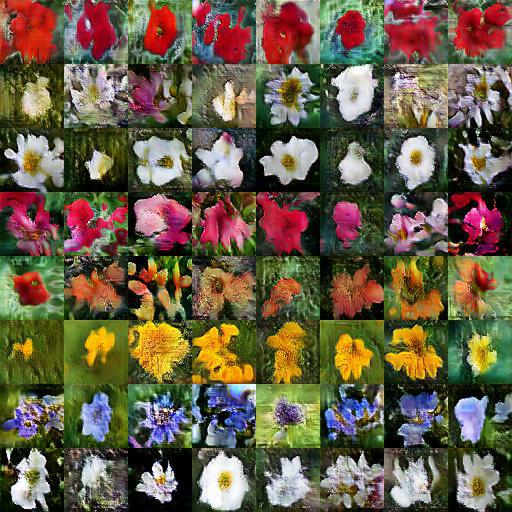

Epoch 21, gen_loss: 26.5401, disc_loss: 4.1029
Time for epoch 21 is 64.1075 sec
Epoch 22, gen_loss: 23.6842, disc_loss: 4.6971
Time for epoch 22 is 63.5493 sec
Epoch 23, gen_loss: 27.3116, disc_loss: 3.7201
Time for epoch 23 is 64.0686 sec
Epoch 24, gen_loss: 25.9001, disc_loss: 3.9432
Time for epoch 24 is 64.0593 sec
Epoch 25, gen_loss: 24.0312, disc_loss: 4.6269
Time for epoch 25 is 64.1103 sec
Epoch 26, gen_loss: 27.0938, disc_loss: 3.2761
Time for epoch 26 is 64.1316 sec
Epoch 27, gen_loss: 26.8466, disc_loss: 4.2871
Time for epoch 27 is 64.2588 sec
Epoch 28, gen_loss: 27.4886, disc_loss: 3.7428
Time for epoch 28 is 64.3120 sec
Epoch 29, gen_loss: 27.4657, disc_loss: 3.7849
Time for epoch 29 is 64.1793 sec
Epoch 30, gen_loss: 16.0082, disc_loss: 7.1692
Time for epoch 30 is 64.1896 sec


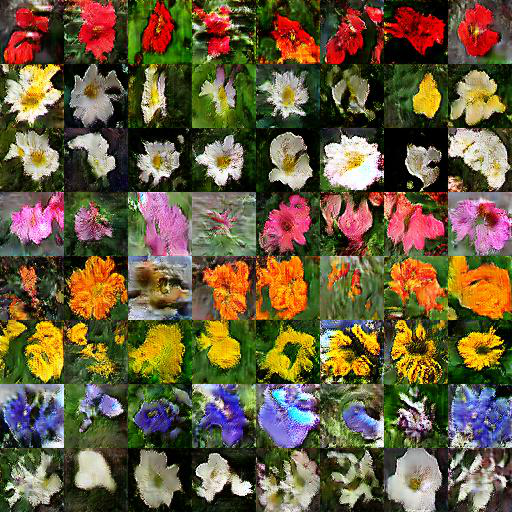

Epoch 31, gen_loss: 24.6452, disc_loss: 2.9841
Time for epoch 31 is 63.0696 sec
Epoch 32, gen_loss: 29.6096, disc_loss: 2.6035
Time for epoch 32 is 61.7872 sec
Epoch 33, gen_loss: 31.4547, disc_loss: 2.8716
Time for epoch 33 is 62.1411 sec
Epoch 34, gen_loss: 29.7238, disc_loss: 4.1913
Time for epoch 34 is 61.9505 sec
Epoch 35, gen_loss: 18.0807, disc_loss: 5.7305
Time for epoch 35 is 61.1018 sec
Epoch 36, gen_loss: 29.2625, disc_loss: 2.1844
Time for epoch 36 is 61.9734 sec
Epoch 37, gen_loss: 32.6446, disc_loss: 3.2618
Time for epoch 37 is 61.2018 sec
Epoch 38, gen_loss: 27.7724, disc_loss: 3.0054
Time for epoch 38 is 62.2007 sec
Epoch 39, gen_loss: 16.7596, disc_loss: 9.4665
Time for epoch 39 is 61.4315 sec
Epoch 40, gen_loss: 19.6627, disc_loss: 4.5097
Time for epoch 40 is 62.0843 sec


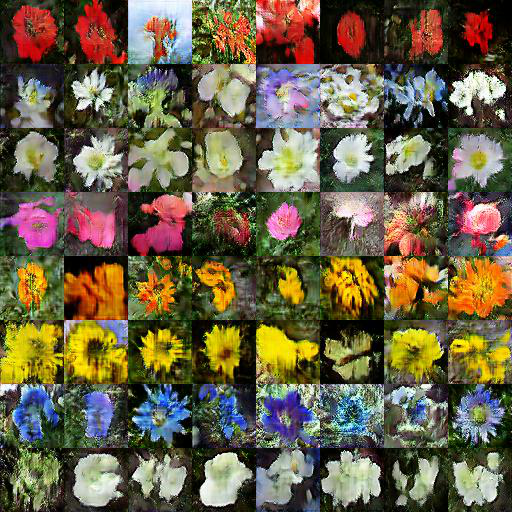

Epoch 41, gen_loss: 27.0087, disc_loss: 2.4663
Time for epoch 41 is 62.0714 sec
Epoch 42, gen_loss: 32.1770, disc_loss: 2.1636
Time for epoch 42 is 62.0599 sec
Epoch 43, gen_loss: 34.2227, disc_loss: 2.1602
Time for epoch 43 is 61.9320 sec
Epoch 44, gen_loss: 33.8511, disc_loss: 3.2990
Time for epoch 44 is 61.9995 sec
Epoch 45, gen_loss: 18.2567, disc_loss: 5.7772
Time for epoch 45 is 61.7204 sec
Epoch 46, gen_loss: 31.1326, disc_loss: 1.9798
Time for epoch 46 is 62.1240 sec
Epoch 47, gen_loss: 28.4132, disc_loss: 5.1231
Time for epoch 47 is 61.8438 sec
Epoch 48, gen_loss: 25.3041, disc_loss: 2.9232
Time for epoch 48 is 62.1005 sec
Epoch 49, gen_loss: 37.2805, disc_loss: 1.4822
Time for epoch 49 is 62.0277 sec
Epoch 50, gen_loss: 36.5349, disc_loss: 2.2565
Time for epoch 50 is 61.3445 sec


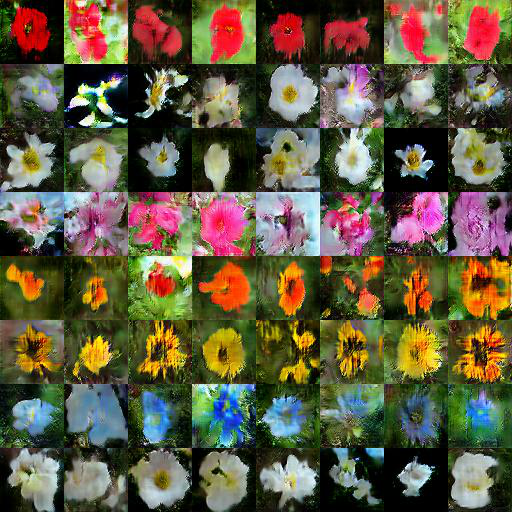

Epoch 51, gen_loss: 33.7183, disc_loss: 2.9475
Time for epoch 51 is 61.0949 sec
Epoch 52, gen_loss: 23.0140, disc_loss: 3.9600
Time for epoch 52 is 62.0718 sec
Epoch 53, gen_loss: 35.8389, disc_loss: 1.8382
Time for epoch 53 is 62.1876 sec
Epoch 54, gen_loss: 32.3247, disc_loss: 3.1197
Time for epoch 54 is 62.1494 sec
Epoch 55, gen_loss: 42.3427, disc_loss: 1.2230
Time for epoch 55 is 62.2934 sec
Epoch 56, gen_loss: 61.5699, disc_loss: 0.6521
Time for epoch 56 is 62.2500 sec
Epoch 57, gen_loss: 72.2418, disc_loss: 0.8377
Time for epoch 57 is 62.0520 sec
Epoch 58, gen_loss: 73.1264, disc_loss: 0.8524
Time for epoch 58 is 62.1473 sec
Epoch 59, gen_loss: 80.1086, disc_loss: 0.2451
Time for epoch 59 is 61.3491 sec


KeyboardInterrupt: 

In [70]:
train(dataset, hparas['N_EPOCH']) 

In [ ]:
############################################################

## Testing dataset 

In [40]:
def id_to_string_for_testdata(ids):
    length = len(ids)
    caption = []
    for i in range(length):
        caption.append(ids[i])
    for cap in range(len(caption)):
        caption_text = ""
        for word in caption[cap]:
            if id2word_dict[word] != '<PAD>':
                caption_text += id2word_dict[word]
                caption_text += ' '
        caption[cap] = caption_text
    strings = np.asarray(caption)
    return strings

def testing_dataset_generator(batch_size):
    caption = id_to_string_for_testdata(captions)

    index = data['ID'].values
    index = np.asarray(index)
    
    dataset = tf.data.Dataset.from_tensor_slices((caption, index))
    dataset = dataset.repeat().batch(batch_size)
    
    return dataset

In [41]:
data = pd.read_pickle(data_path +'/testData.pkl')
captions = data['Captions'].values
NUM_TEST = len(captions)
EPOCH_TEST = int(NUM_TEST / hparas['BATCH_SIZE'])


In [42]:
testing_dataset = testing_dataset_generator(hparas['BATCH_SIZE'])

## Inference  


In [123]:
def inference(dataset):
#     hidden = text_encoder.initialize_hidden_state()
    sample_size = hparas['BATCH_SIZE']
    sample_seed = np.random.normal(loc=0.5, scale=0.5, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
    
    step = 0
    start = time.time()
    for captions, idx in dataset:
        #print(captions.shape)
        if step > EPOCH_TEST:
            break
        
        fake_image = test_step(captions, sample_seed)
        step += 1
        for i in range(hparas['BATCH_SIZE']):
            plt.imsave('./infer_test/inference_{:04d}.jpg'.format(idx[i]), fake_image[i].numpy()*0.5 + 0.5)
            #print("number of captions:",idx[i])
            #print('captions: ',captions[i])
            
    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [69]:
def visualize(idx):
    fig = plt.figure(figsize=(14, 14))
    
    for count, i in enumerate(idx):
        loc = np.where(i==index)[0][0]
        text = ''
        for word in captions[loc]:
            if id2word_dict[word] != '<PAD>':
                text += id2word_dict[word]
                text += ' '
        print(text)
        
        path = './infe_test/inference_{:04d}.jpg'.format(i)
        fake_iamge = plt.imread(path)
        
        plt.subplot(7, 7, count+1)
        plt.imshow(fake_iamge)
        plt.axis('off')

In [77]:
checkpoint.restore(checkpoint_dir + '/ckpt-54')

In [49]:
inference(testing_dataset)

In [50]:
%cd testing
!python inception_score.py ../inference/ ../scoreCheck.csv 39
%cd ..

/home/112062611/dl/dataset/Comp3/testing
1 Physical GPUs, 1 Logical GPUs
--------------Evaluation Success-----------------
/home/112062611/dl/dataset/Comp3


In [51]:
import os
import pandas as pd
import numpy as np
score_file="./scoreCheck.csv"
if os.path.exists(score_file):
    df_score = pd.read_csv(score_file)
    mean_score = np.mean(df_score['score'].values)
    print(f'Mean Score: {mean_score:f}'+' ')
else:
    print('Evaluation Failed!')

Mean Score: 0.460410 


# combine picture

flower with white long white petals and very long purple stamen 
this medium white flower has rows of thin blue petals and thick stamen 
this flower is white and purple in color with petals that are oval shaped 
this flower is pink and yellow in color with petals that are oval shaped 
the flower has a large bright orange petal with pink anther 
the flower shown has a smooth white petal with patches of yellow as well 
white petals that become yellow as they go to the center where there is an orange stamen 
this flower has bright red petals with green pedicel as its main features 
this flower has the overlapping yellow petals arranged closely toward the center 
this flower has green sepals surrounding several layers of slightly ruffled pink petals 
the pedicel on this flower is purple with a green sepal and rose colored petals 
this white flower has connected circular petals with yellow stamen 
the flower has yellow petals overlapping each other and are yellow in color 
this flower has n

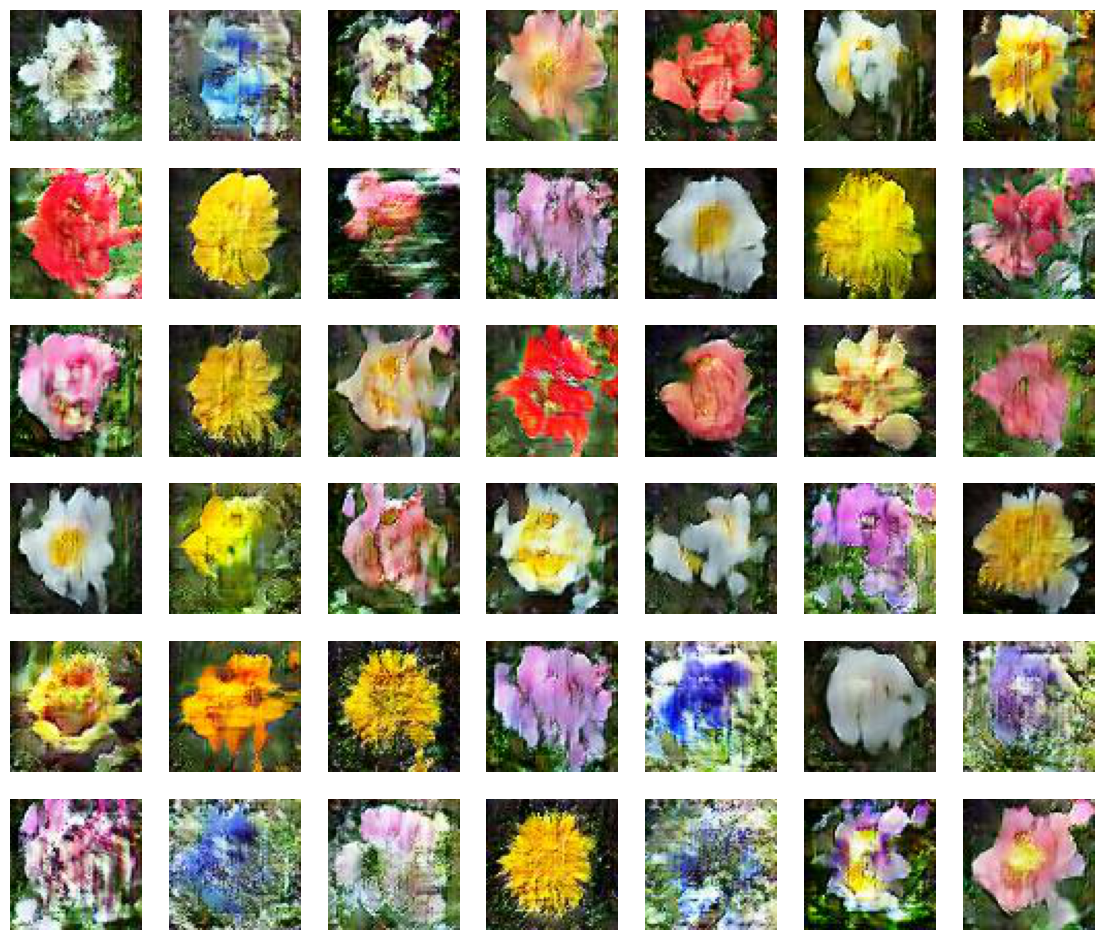

In [53]:
data = pd.read_pickle('./dataset/testData.pkl')
captions = data['Captions'].values
index = data['ID'].values
random_idx = [23, 216, 224, 413, 713, 859, 876, 974, 1177, 1179, 1241, 2169, 2196, 2237, 
              2356, 2611, 2621, 2786, 2951, 2962, 3145, 3255, 3327, 3639, 3654, 3927, 4262, 
              4321, 4517, 5067, 5147, 5955, 6167, 6216, 6410, 6413, 6579, 6584, 6804, 6988, 
              7049, 7160]

visualize(random_idx)

this flower is white and yellow in color with petals that are rounded and large 
this flower is yellow in color with petals that are oval shaped 
the flower has a set of bell shaped petals with its inner core filled with black dots 
this flower has orange and red mouth colors surrounded by pink petals with ruffled edges 
this flower has ruffled pale yellow petals atop rounded purple petals with curved edges 
the flower has six long purple petals with dark pink stripes in the middle 
this flower has petals that are red with white stamen 
the petals of the flower are pointed in shape and have an inner layer that is red in color 
the flower has pink petals that are long and oval shaped 
a flower with orange yellow petals and orange anther filaments and pistils 
sepals are green in color petals are floret and are yellow in color 
the petals of the flower are yellow and have curled edges 
the flower has petals that are red with white edges and red filaments 
this flower is purple in color w

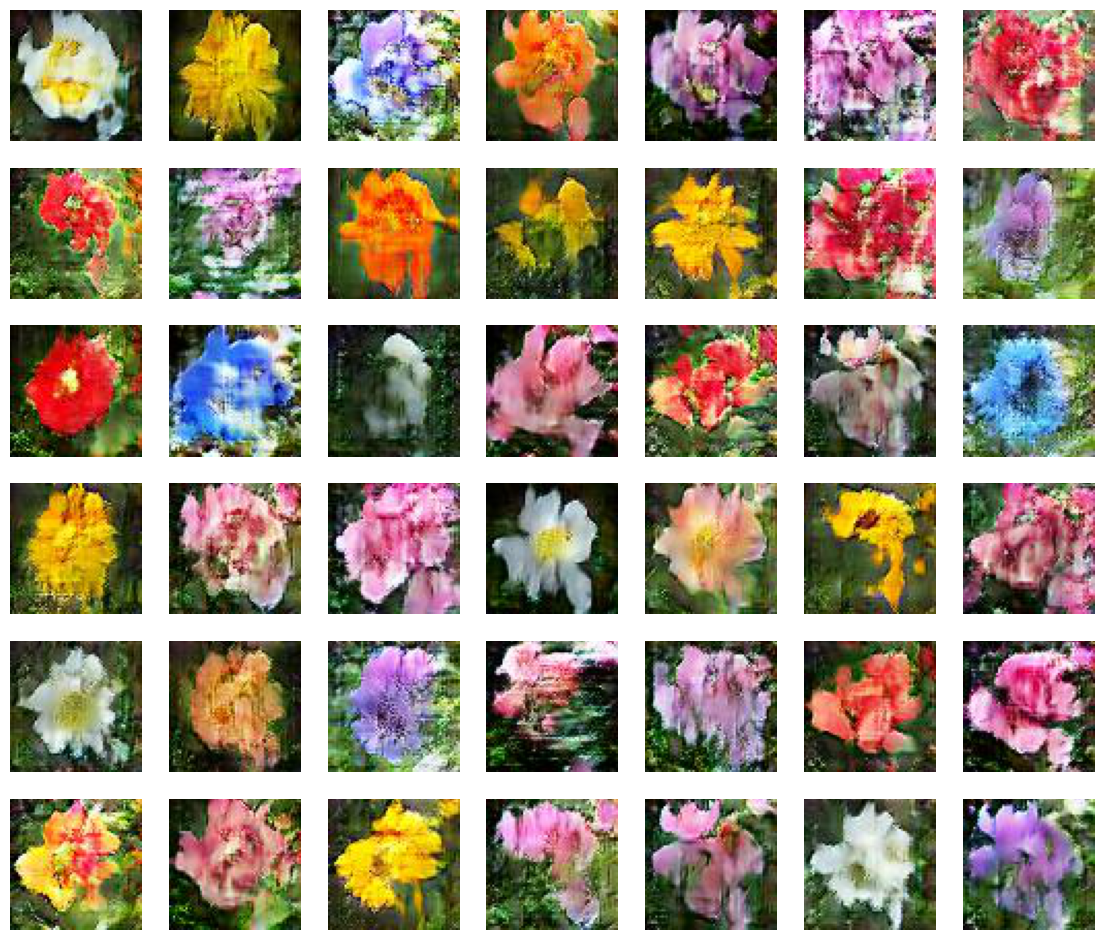

In [64]:
DATA_PATH = './inference/'
img_path = Path(DATA_PATH).glob('*.jpg')
img_path = [str(path.resolve()) for path in img_path]
img_path = np.asarray(img_path)

idx = np.random.randint(len(captions), size=42)
idx.sort()

random_idx = []
for each in idx:
    path = img_path[each].split("/")
    path = path[-1].replace('inference_', '')
    random_idx.append(int(path.replace('.jpg', '')))
    
visualize(random_idx)

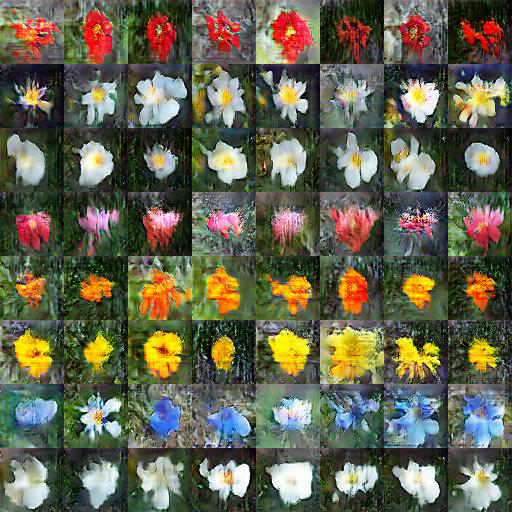

In [116]:
# 訓練圖
sample_seed=np.random.normal(loc=-0.8, scale=0.7, size=(sample_size, hparas['Z_DIM'])).astype(np.float32)
for caption in sample_sentence:
    fake_image = test_step(caption, sample_seed)
save_images(fake_image, [ni, ni], './train.jpg')
img=Image.open('./train.jpg')
display.display(img)

In [95]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  0 (unused)
_________________________________________________________________
sequential (Sequential)      (64, 4, 4, 1024)          16842752  
_________________________________________________________________
sequential_1 (Sequential)    (64, 8, 8, 512)           4720640   
_________________________________________________________________
conv_leaky_relug (conv_leaky multiple                  66048     
_________________________________________________________________
conv_leaky_relug_1 (conv_lea multiple                  147968    
_________________________________________________________________
convg (convg)                multiple                  591872    
_________________________________________________________________
sequential_2 (Sequential)    (64, 16, 16, 256)         11

In [92]:
discriminator.summary()

Model: "discriminator_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           multiple                  3072      
_________________________________________________________________
conv_leaky_relu_21 (conv_lea multiple                  131584    
_________________________________________________________________
conv_leaky_relu_22 (conv_lea multiple                  525312    
_________________________________________________________________
conv_leaky_relu_23 (conv_lea multiple                  2099200   
_________________________________________________________________
conv_leaky_relu_24 (conv_lea multiple                  66048     
_________________________________________________________________
conv_leaky_relu_25 (conv_lea multiple                  147968    
_________________________________________________________________
conv_leaky_relu_26 (conv_lea multiple              